In [212]:
import numpy as np
import pandas as pd
from scipy import stats

import xarray as xr
import os
import matplotlib.pyplot as plt

import sys
from bslibs.plot.qqplot import qqplot
import seaborn as sns

In [219]:
df = pd.read_csv("/mnt/temp/projects/emergence/data_keep/station_data/dunedin_btl_gardens_precip.tsv",sep='\t', parse_dates=['Date(UTC)'], skiprows=8)

In [224]:
df

,Station,Date(UTC),Amount(mm),Rel,Orig,SofG,Deficit(mm),Runoff(mm),Rel.1,Orig.1,Period(Hrs),Freq
0,5375,19130101:2100,0.0,-,D,-,-,-,-,-,24,D
1,5375,19130102:2100,0.0,-,D,-,-,-,-,-,24,D
2,5375,19130103:2100,0.0,-,D,-,-,-,-,-,24,D
3,5375,19130104:2100,0.0,-,D,-,-,-,-,-,24,D
4,5375,19130105:2100,0.0,-,D,-,-,-,-,-,24,D
...,...,...,...,...,...,...,...,...,...,...,...,...
37547,5375,20200225:2000,0.0,-,D,-,51.0,0.0,*,H,24,D
37548,5375,20200226:2000,0.0,-,D,-,54.3,0.0,*,H,24,D
37549,5375,20200227:2000,0.0,-,D,-,57.6,0.0,*,H,24,D
37550,5375,20200228:2000,0.0,-,D,-,61.0,0.0,*,H,24,D


In [227]:
df['date'] = pd.to_datetime(df['Date(UTC)'].values, format='%Y%m%d:%H%M')
precip = pd.Series(df['Amount(mm)'].values, index=df['date'].values)


In [228]:
precip.index

DatetimeIndex(['1913-01-01 21:00:00', '1913-01-02 21:00:00',
               '1913-01-03 21:00:00', '1913-01-04 21:00:00',
               '1913-01-05 21:00:00', '1913-01-06 21:00:00',
               '1913-01-07 21:00:00', '1913-01-08 21:00:00',
               '1913-01-09 21:00:00', '1913-01-10 21:00:00',
               ...
               '2020-02-20 20:00:00', '2020-02-21 20:00:00',
               '2020-02-22 20:00:00', '2020-02-23 20:00:00',
               '2020-02-24 20:00:00', '2020-02-25 20:00:00',
               '2020-02-26 20:00:00', '2020-02-27 20:00:00',
               '2020-02-28 20:00:00', '2020-02-29 20:00:00'],
              dtype='datetime64[ns]', length=37552, freq=None)

In [229]:
samples = np.linspace(0, precip.max() ,1000)
samples_prob = np.linspace(0, 1.0 ,1000, endpoint=False)
rain_day = .1 # Rain day threshold
ext_thresh = 50

In [230]:
rain_mask = (precip > rain_day) & (precip < ext_thresh) 
ext_mask = (precip >= ext_thresh)
rain_mask.sum()/len(rain_mask)

0.4653280783979548

In [231]:
dist = stats.weibull_min

In [232]:
precip_only = precip[rain_mask] - rain_day
extremes_only = precip[ext_mask] - ext_thresh

In [233]:
fit_coef = dist.fit(precip_only - rain_day)
cdf = dist.cdf(samples, *fit_coef)

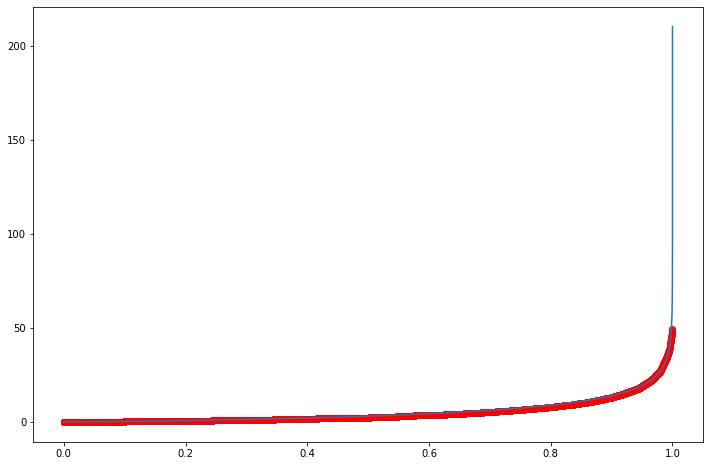

In [234]:
plt.figure(figsize=(12,8))
plt.plot(cdf, samples)
plt.scatter(np.linspace(0, 1, len(precip_only), endpoint=False), sorted(precip_only), c='r', alpha=0.3)

In [235]:
preds = dist.rvs(*fit_coef, 365*100)

In [236]:
precip_q = np.quantile(precip_only.values, samples_prob)
preds_q = dist.ppf(samples_prob, *fit_coef)

<AxesSubplot:>

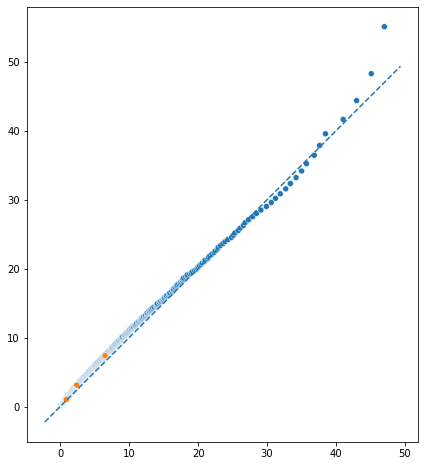

In [237]:
plt.figure(figsize=(20, 8))
qqplot(precip_q, preds_q)

In [238]:
extremes_only.index

DatetimeIndex(['1913-08-13 21:00:00', '1913-08-24 21:00:00',
               '1916-06-20 21:00:00', '1920-08-07 21:00:00',
               '1923-04-22 21:00:00', '1924-10-04 21:00:00',
               '1925-03-04 21:00:00', '1926-10-10 21:00:00',
               '1927-03-23 21:00:00', '1927-07-26 21:00:00',
               ...
               '2013-05-05 21:00:00', '2013-06-16 21:00:00',
               '2015-06-03 21:00:00', '2016-05-22 21:00:00',
               '2017-01-22 20:00:00', '2017-04-12 21:00:00',
               '2017-07-21 21:00:00', '2018-02-01 20:00:00',
               '2018-04-29 21:00:00', '2020-02-04 20:00:00'],
              dtype='datetime64[ns]', length=130, freq=None)

In [256]:
fit_ext = stats.genpareto.fit(extremes_only, floc=0, scale=extremes_only.std())

In [258]:
precip_q = np.quantile(extremes_only.values, samples_prob)
preds_q =  stats.genpareto.ppf(samples_prob, *fit_ext)

<AxesSubplot:>

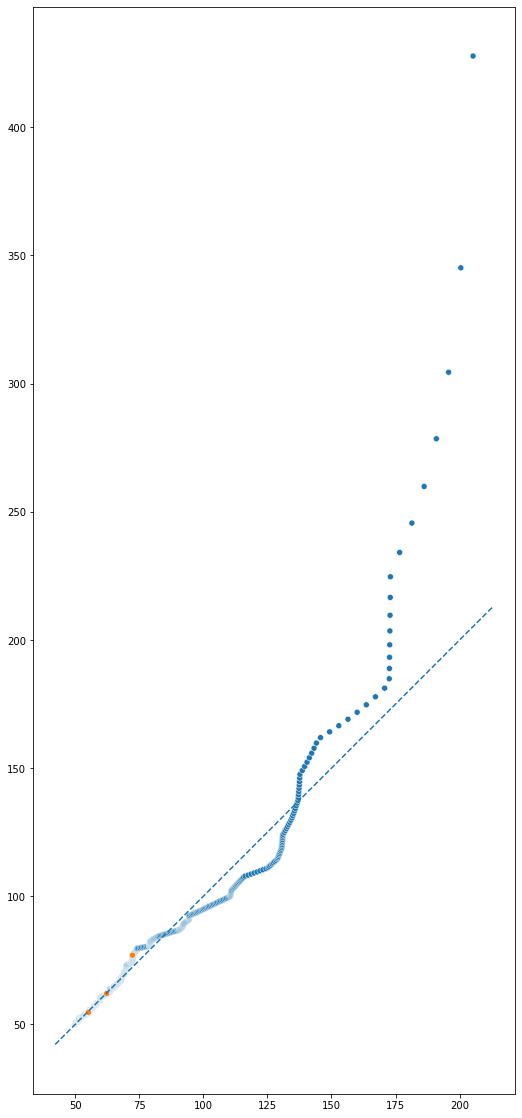

In [259]:
plt.figure(figsize=(20, 20))
qqplot(precip_q + ext_thresh, preds_q + ext_thresh)

In [ ]:
def plot_growth(pred_loc, station_data : pd.DataFrame, block_size, scaler, t_primes=[0.2, 1.2], max_return=200,
                figsize=(12, 8), fit_gev=False, show=True, title=None, ylim=None):
    # Creates a 'growth' plot, does not use plt.show or plt.savefig, instead just returns 
    # Creates a log based gev plot
    plt.figure(figsize=figsize)

    if title:
        plt.title(title)

    # Adjust return period for block size
    bs_ret = max_return / block_size
    samples = np.linspace(0.01, 1.0-(1/(bs_ret+1)), 1000)
    return_periods = (1/(1 - samples))*block_size

    # Recalculate the block maximia
    if block_size > 1:
        data = station_utils.multi_year_bmax_rnd(station_data, bs=block_size)['data'].values
    else:
        data = station_data['data'].values

    # Make a scatter plot
    data_s = sorted(data)
    plt.scatter(np.flip(len(data_s)/np.arange(1, len(data_s)+1))*block_size, data_s, label='Measurements', c='k')

    if fit_gev:
        ge_res = ss.genextreme.fit(data)
        pr = ss.genextreme.ppf(samples, *ge_res)
        plt.plot(return_periods, pr, linewidth=3, label='GEV fit to observations')

    for t_p in t_primes:
        shape, loc, scale  = get_params_temp(pred_loc[None, :], t_p)
        pr_tp = get_ppf(shape, loc, scale, samples, scaler)
        plt.plot(return_periods, pr_tp, linewidth=2, label=f'NN-GEV at {t_p}k')

    plt.xscale('log')
    plt.xlabel("Return Period", fontsize=12)
    plt.ylabel('Precipitation [mm]')
    plt.xlim(block_size, max_return)

    if ylim:
        plt.ylim(ylim)

    plt.xlim(block_size, 200)
    plt.legend()

(shape,loc,scale) = (0.5981545318590642, 0.09999999999999999, 3.370276569692341)


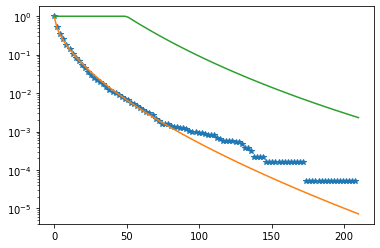

In [3]:
dunedin_rf = df['Amount(mm)'].values
samples = np.linspace(0,np.max(dunedin_rf),100)
rain_day = 0.1 #Change Censor value here 

ecdf = np.array(list(map(lambda x: np.sum(dunedin_rf[dunedin_rf>=censor] <= x)/np.sum(dunedin_rf>=censor),sample_space)))

fit = stats.weibull_min.fit(dunedin_rf[dunedin_rf>=censor])
acdf = stats.weibull_min.cdf(sample_space,*fit)

fit_2 = stats.genpareto.fit(dunedin_rf[dunedin_rf>=50])
acdf_p = stats.genpareto.cdf(sample_space,*fit_2)

plt.plot(sample_space,1-ecdf,'*')
plt.plot(sample_space,1-acdf) #orange line
plt.plot(sample_space,1-acdf_p) #green line
plt.yscale('log')

print(f"(shape,loc,scale) = {fit}")